In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import POD, DMD, ROM, KERDMD
import matplotlib.pyplot as plt
import scipy.interpolate as si

## Loading Data from simulation results

In [2]:
case = 0 # 0 if mass = 1000 case; 1 if mass = 350 
if case == 0:
    folder_name = "../DATA/Fsi/Fsi_Results/"
else:
    folder_name = "../DATA/Fsi/Fsi_Results_mass_350/"

pist_pressure = np.load(folder_name+"pist_pressure.npy")
nnt = pist_pressure.shape[0]
fl_pressure = np.load(folder_name+"fl_pressure.npy")
fl_rho_e = np.load(folder_name+"fl_rho_e.npy")
fl_rho_v = np.load(folder_name+"fl_rho_v.npy")
fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
fl_rho = np.load(folder_name+"fl_rho.npy")
moving_mesh = np.load(folder_name+"fl_moving_mesh.npy")
delta_t = np.load(folder_name+"delta_t.npy")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho
s_accel = np.load(folder_name+"sol_accel.npy")
Ec = np.load(folder_name+"Ec.npy")
Em = np.load(folder_name+"Em.npy")
Ep = np.load(folder_name+"Ep.npy")
Imp_fl = np.load(folder_name+"Imp_fl.npy")

t_data = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]

## Problem parameters 
L = 1 # Piston (gas chamber) length
L0 = 1 # Initial Piston (gas chamber) length
mass = 1000 # Mass of the spring
rigid = 1e7  # stiffeness of the spring
Ls0 = 1.2 # Unstretched spring length
Lse = Ls0 - 1e5 / rigid # Length under pressure at rest

In [3]:
folder_name = "../DATA/Fsi/res_longer_time/"

pist_pressure_long = np.load(folder_name+"pist_pressure.npy")
nnt_long = pist_pressure_long.shape[0]
fl_pressure_long = np.load(folder_name+"fl_pressure.npy")
fl_rho_v_long = np.load(folder_name+"fl_rho_v.npy")
fl_rho_long = np.load(folder_name+"fl_rho.npy")
moving_mesh_long = np.load(folder_name+"moving_mesh.npy")
delta_t_long = np.load(folder_name+"delta_t.npy")
fl_velocity_long = fl_rho_v_long/fl_rho_long
s_accel_long = np.load(folder_name+"sol_accel.npy")


t_data_long = np.cumsum(delta_t_long)
nt_long = fl_pressure_long.shape[1]

In [4]:
folder_name = "../DATA/Fsi/res_longer_time_nln/"

pist_pressure_long_nln = np.load(folder_name+"pist_pressure.npy")
nnt_long_nln = pist_pressure_long_nln.shape[0]
fl_pressure_long_nln = np.load(folder_name+"fl_pressure.npy")
fl_rho_v_long_nln = np.load(folder_name+"fl_rho_v.npy")
fl_rho_long_nln = np.load(folder_name+"fl_rho.npy")
moving_mesh_long_nln = np.load(folder_name+"moving_mesh.npy")
delta_t_long_nln = np.load(folder_name+"delta_t.npy")
fl_velocity_long_nln = fl_rho_v_long_nln/fl_rho_long_nln
s_accel_long_nln = np.load(folder_name+"sol_accel.npy")


t_data_long_nln = np.cumsum(delta_t_long_nln)
nt_long_nln = fl_pressure_long_nln.shape[1]

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [5]:
# Training data
X = fl_pressure

In [6]:
pod = POD()
roml = ROM(pod)
roml.decompose(X)

In [7]:
rank = 4
rec_X = roml.reconstruct(rank)

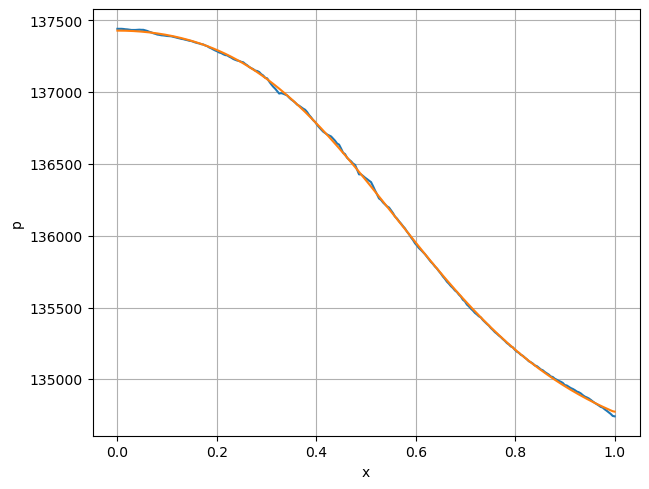

In [8]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , -1]);
plt.plot(domain, rec_X[: ,  -1]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

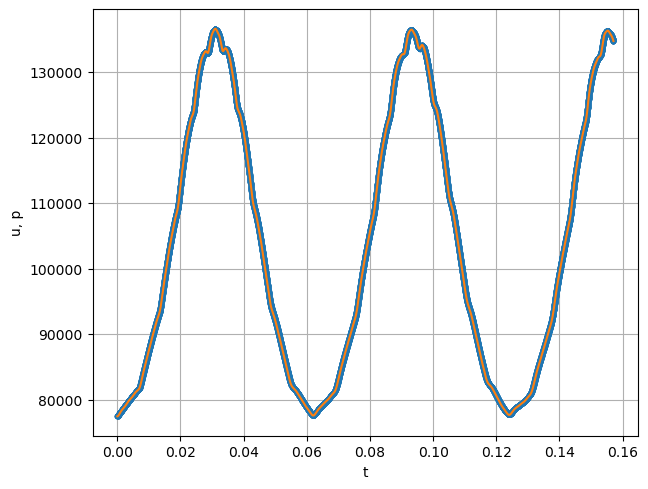

In [9]:
plt.plot(t_data, X[-1, :], '.');
plt.plot(t_data, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**The High Fidelity (HF) solution**

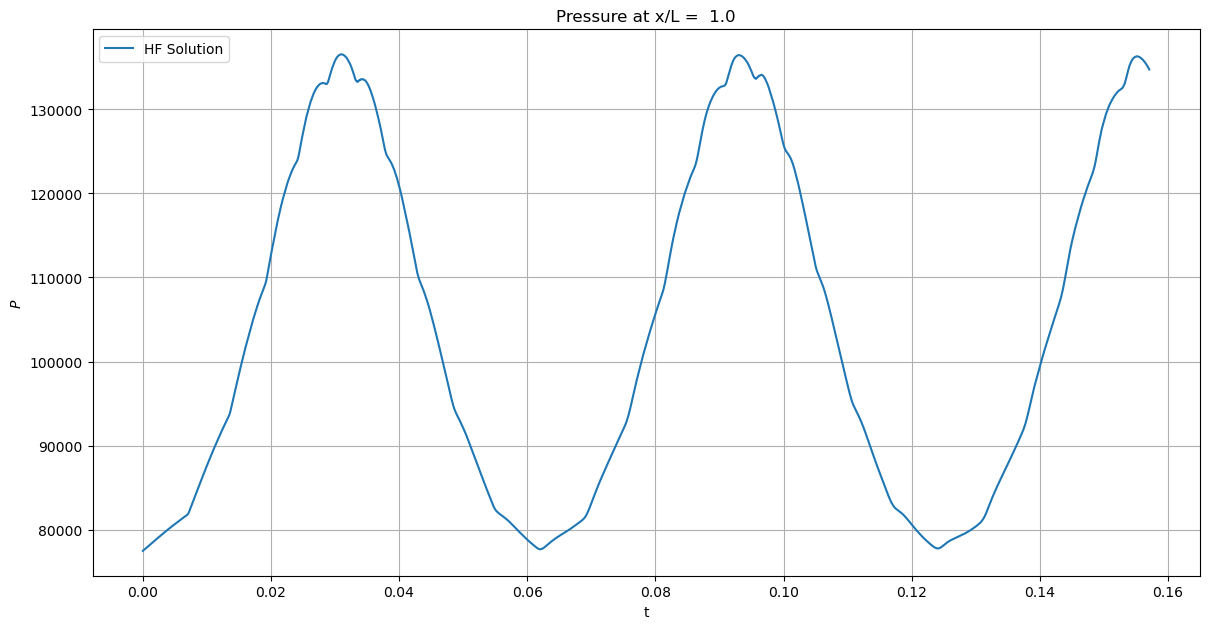

In [10]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))

plt.plot(t_data, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

The HF solution captures 2.5 periods of the system, we will train the ROM on 1.75 periods and 200 points and the rest will be used for testing

**Interpolate to fixed time intervals**

In [11]:
# Choose number of equally spaced timesteps 
n_T = 2.5 # ~ Number of modes in data
n_snap = 280 # Number of snapshots in the train data
frac = 1.8 # ~ Number of time periods in the train data
ntt = int(n_snap /(frac/n_T)) # Number of snapshots in the test+train data
dt = (t_data[-1] - t_data[0]) / (ntt - 1) # New (fixed) time step

# Interpolating original data to the new timesteps
t = np.linspace(t_data[0], t_data[-1], ntt)
pressure = si.griddata(t_data, fl_pressure.T, t, method='nearest').T
velocity = si.griddata(t_data, fl_velocity.T, t, method='nearest').T
mesh = si.griddata(t_data, moving_mesh.T, t, method='nearest').T
sol_accel = si.griddata(t_data, s_accel.T, t, method='nearest').T

**Separating training and testing data**

In [12]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/n_T

## Training data ============================
train_pressure = pressure[:, :int(Coeff*ntt)]
train_velocity = velocity[:, :int(Coeff*ntt)]
train_mesh = mesh[:, :int(Coeff*ntt)]
train_sol_accel = sol_accel[:int(Coeff*ntt)][np.newaxis, :]
train_t = t[:int(Coeff*ntt)]

## Testing data ============================
test_pressure = pressure[:, int(Coeff*ntt)::]
test_velocity = velocity[:, int(Coeff*ntt)::]
test_mesh = mesh[:, int(Coeff*ntt)::]
test_sol_accel = sol_accel[int(Coeff*ntt)::][np.newaxis, :]
test_t = t[int(Coeff*ntt)::]

train_data_1 = np.concatenate((train_pressure, train_velocity, train_mesh))
train_data_2 = np.concatenate((train_pressure, train_velocity,))
train_data_3 = np.concatenate((train_pressure, train_velocity, train_mesh, train_sol_accel))

# Training data (Disregarding solid acceleration)
X = train_data_1[:, :-1]
Y = train_data_1[:, 1::]

# Training data (Disregarding mesh displacement)
X2 = train_data_2[:, :-1]
Y2 = train_data_2[:, 1::]

# Training data (Disregarding mesh displacement)
X3 = train_data_3[:, :-1]
Y3 = train_data_3[:, 1::]

**DMD reduction**

In [13]:
rank = 0
dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, rank =rank, normalize=True, center = False)

In [14]:
rank = 0
dmd2 = DMD()
drom2 = ROM(dmd2)
drom2.decompose(X2,  Y = Y2, dt = dt, rank =rank, normalize=True, center = False)

In [15]:
rank = 0
dmd3 = DMD()
drom3 = ROM(dmd3)
drom3.decompose(X3,  Y = Y3, dt = dt, rank =rank, normalize=True, center = False)

In [16]:
rank = 0
kdmd = KERDMD()
kdrom = ROM(kdmd)
kdrom.decompose(X3,  Y = Y3, dt = dt, rank =rank, normalize=True, center = False, p = 3)

**DMD modes**

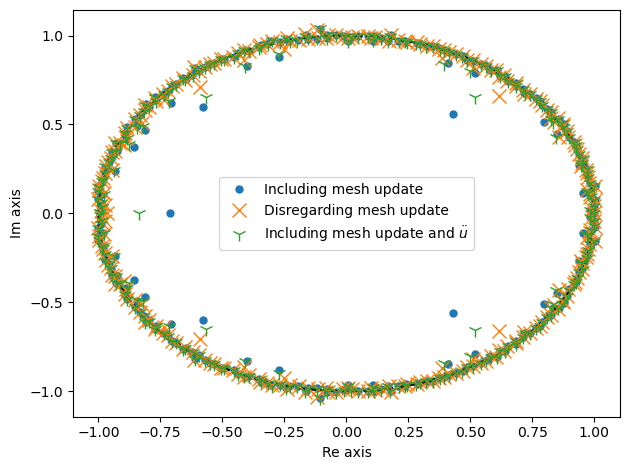

In [17]:
plt.plot(np.real(drom.model.lambd), np.imag(drom.model.lambd), '.', markersize = 10, label = "Including mesh update");
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");
plt.plot(np.real(drom2.model.lambd), np.imag(drom2.model.lambd), 'x', markersize = 10, label = "Disregarding mesh update");
plt.plot(np.real(drom3.model.lambd), np.imag(drom3.model.lambd), '1', markersize = 10, label = r"Including mesh update and $\ddot{u}$");
plt.legend();
plt.tight_layout();

## Reconstructing X

In [21]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1
satbilize_ = True
prediction_t = np.concatenate((t, np.linspace(t[-1] + dt, 3.2 * t[-1], int(ntt))))
predicted_X = np.real(drom.predict(prediction_t, t1 = t[0], stabilize=satbilize_))
predicted_X2 = np.real(drom2.predict(prediction_t, t1 = t[0], stabilize=satbilize_))
predicted_X3 = np.real(drom3.predict(prediction_t, t1 = t[0], stabilize=satbilize_,))

predicted_mesh = predicted_X[2 * nx::, :]
predicted_pressure = predicted_X[:nx, :]
predicted_pressure_nomesh = predicted_X2[:nx, :]
predicted_pressure_accel = predicted_X3[:nx, :]
predicted_mesh_accel = predicted_X3[2 * nx: 3*nx, :]
predicted_velocity = predicted_X[nx:2*nx, :]
predicted_velocity_nomesh = predicted_X2[nx:2*nx, :]
predicted_velocity_accel = predicted_X3[nx:2*nx, :]

pred_kX = np.real(kdrom.predict(prediction_t, t1 = t[0], stabilize=satbilize_,))

k_predicted_pressure = pred_kX[:nx, :]
k_predicted_mesh_accel = pred_kX[2 * nx: 3*nx, :]
k_predicted_velocity = pred_kX[nx:2*nx, :]


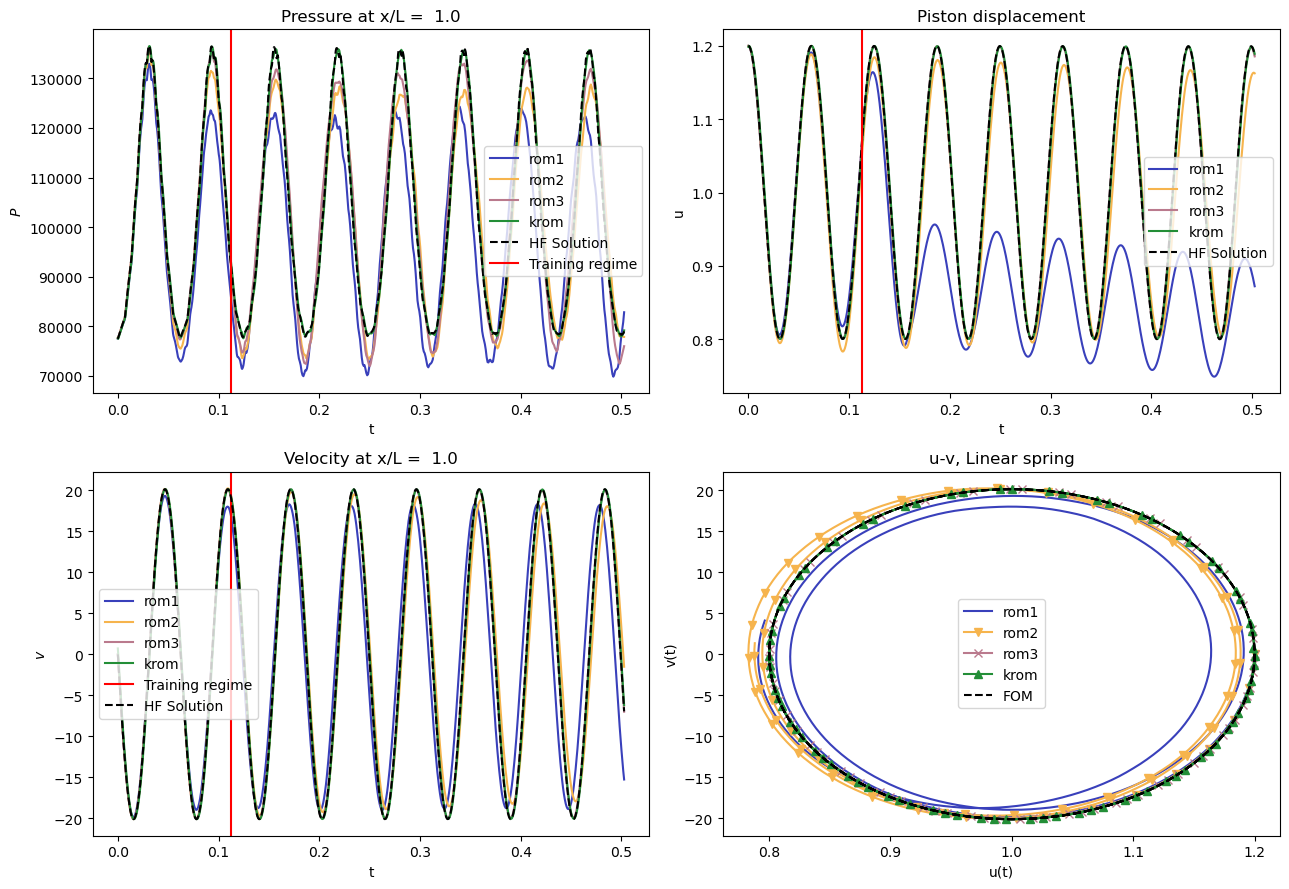

In [23]:
x_n = 1
fig, ax = plt.subplots(2, 2, figsize = (13., 9.))

ax[0, 0].plot(prediction_t, predicted_pressure_nomesh[-x_n, :], '-',  color ="#3940bb",  markersize = 4, markevery = 5, label = "rom1")
ax[0, 0].plot(prediction_t, predicted_pressure[-x_n, :], '-', markevery = 5, color = '#f6b44d', label = "rom2")
ax[0, 0].plot(prediction_t, predicted_pressure_accel[-x_n, :], '-', color = "#ba7a8d", markevery = 5, label = "rom3")
ax[0, 0].plot(prediction_t, k_predicted_pressure[-x_n, :], '-', color = "#238E37", label = "krom")
ax[0, 0].plot(t_data_long, fl_pressure_long[-x_n, :], '--k', markevery = 5, label = "HF Solution");
ax[0, 0].axvline(train_t[-1], color = 'red', label = 'Training regime')
ax[0, 0].legend();
#ax[0, 0].grid();

ax[0, 0].set_xlabel("t");
ax[0, 0].set_ylabel("$P$");
ax[0, 0].set_title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));



ax[0, 1].plot(prediction_t, np.cumsum(predicted_velocity_nomesh[-1, :]*dt)+1.2, color ="#3940bb",  label = "rom1");
ax[0, 1].plot(prediction_t, predicted_mesh[-1, :], '-', color = '#f6b44d',label = "rom2");
ax[0, 1].plot(prediction_t, predicted_mesh_accel[-1, :], '-',color = "#ba7a8d", label = "rom3");
ax[0, 1].plot(prediction_t, k_predicted_mesh_accel[-1, :], '-', color = "#238E37",label = "krom");
ax[0, 1].plot(t_data_long, moving_mesh_long[-1, :], '--k', label = "HF Solution");
ax[0, 1].legend();
#ax[0, 1].grid();
ax[0, 1].set_title("Piston displacement");
ax[0, 1].set_xlabel("t");
ax[0, 1].set_ylabel("u");
ax[0, 1].axvline(train_t[-1], color = 'red', label = 'Training regime')


ax[1, 0].plot(prediction_t, predicted_velocity_nomesh[-x_n, :], '-', color ="#3940bb",  label = "rom1")
ax[1, 0].plot(prediction_t, predicted_velocity[-x_n, :], '-',color = '#f6b44d',label = "rom2")
ax[1, 0].plot(prediction_t, predicted_velocity_accel[-x_n, :], '-', color = "#ba7a8d",label = "rom3")
ax[1, 0].plot(prediction_t, k_predicted_velocity[-x_n, :], '-',color = "#238E37", label = "krom")
ax[1, 0].axvline(train_t[-1], color = 'red', label = 'Training regime')
ax[1, 0].plot(t_data_long, fl_velocity_long[-x_n, :], '--k', label = "HF Solution");
ax[1, 0].legend();
#ax[1, 0].grid();
ax[1, 0].set_xlabel("t");
ax[1, 0].set_ylabel("$v$");
ax[1, 0].set_title("Velocity at x/L =  " + str(L * (nx - x_n + 1)/nx));


ax[1, 1].plot(np.cumsum(predicted_velocity_nomesh[-1, :t.shape[0]]*dt)+1.2, predicted_velocity_nomesh[-1, :t.shape[0]], color ="#3940bb",  label = 'rom1');
ax[1, 1].plot(predicted_mesh[-1, :t.shape[0]], predicted_velocity[-1, :t.shape[0]], 'v-', markevery = 5, color = '#f6b44d',label = 'rom2');
ax[1, 1].plot(predicted_mesh_accel[-1, :t.shape[0]], predicted_velocity_accel[-1, :t.shape[0]], '-x', color = "#ba7a8d", markevery = 5, label = 'rom3');
ax[1, 1].plot(k_predicted_mesh_accel[-1, :t.shape[0]], k_predicted_velocity[-1, :t.shape[0]], '-^', color = "#238E37",markevery = 5, label = 'krom');
ax[1, 1].plot(moving_mesh[-1, :], fl_velocity_end[-1, :], '--k', label = 'FOM');
ax[1, 1].legend();
ax[1, 1].set_xlabel("u(t)")
ax[1, 1].set_ylabel("v(t)")
ax[1, 1].set_title(r"u-v, Linear spring");

plt.tight_layout();

In [24]:
predicted_X = np.real(drom.predict(t_data_long, t1 = t[0], stabilize=satbilize_))
predicted_X2 = np.real(drom2.predict(t_data_long, t1 = t[0], stabilize=satbilize_))
predicted_X3 = np.real(drom3.predict(t_data_long, t1 = t[0], stabilize=satbilize_,))
predicted_Xk = np.real(kdrom.predict(t_data_long, t1 = t[0] - dt, stabilize=satbilize_,))

reference = fl_pressure_long[:, 13144:]
predicted1 = predicted_X2[:250, 13144:]
predicted2 = predicted_X[:250, 13144:]
predicted3 = predicted_X3[:250, 13144:]
predictedk = predicted_Xk[:250, 13144:]

error1 = np.sqrt(((predicted1 - reference)**2))/reference
error2 = np.sqrt(((predicted2 - reference)**2))/reference
error3 = np.sqrt(((predicted3 - reference)**2))/reference
errork = np.sqrt(((predictedk - reference)**2))/reference

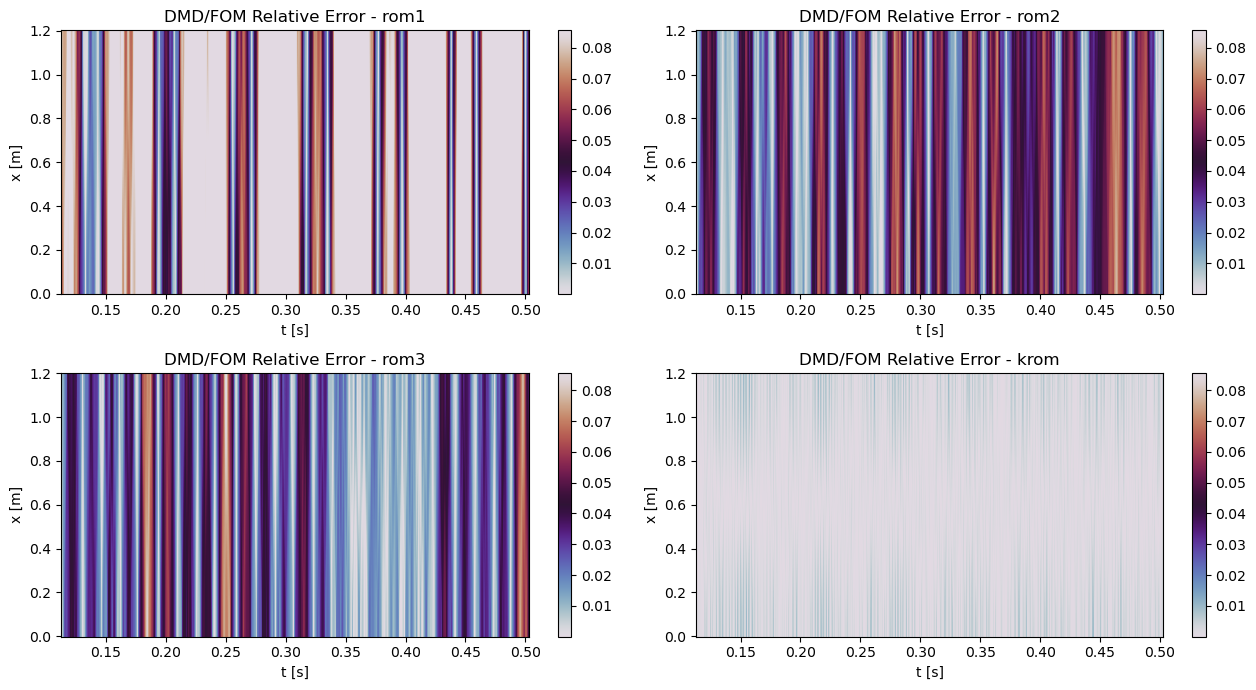

In [25]:
fig, ax = plt.subplots(2, 2, figsize = (13, 7))

x0 = t_data_long[13144:]
y0 = moving_mesh[:, 0]

z1 = error1
z2 = error2
z3 = error3
zk = errork

z_min1, z_max1 = z1.min(), z1.max()
z_min2, z_max2 = z2.min(), z2.max()
z_min3, z_max3 = z3.min(), z3.max()
z_mink, z_maxk = zk.min(), zk.max()
z_min0 = min([z_min1, z_min2, z_min3, z_mink])
z_max0 = max([z_max2, z_max3, z_maxk])


c1 = ax[0, 0].pcolormesh(x0, y0, z1, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)
c2 = ax[0, 1].pcolormesh(x0, y0, z2, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)
c3 = ax[1, 0].pcolormesh(x0, y0, z3, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)
ck = ax[1, 1].pcolormesh(x0, y0, zk, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)

plt.colorbar(c1, ax=ax[0, 0])
plt.colorbar(c2, ax=ax[0, 1])
plt.colorbar(c3, ax=ax[1, 0])
plt.colorbar(ck, ax=ax[1, 1])

ax[0, 0].set_title(r'DMD/FOM Relative Error - rom1')
ax[0, 1].set_title(r'DMD/FOM Relative Error - rom2')
ax[1, 0].set_title(r'DMD/FOM Relative Error - rom3')
ax[1, 1].set_title(r'DMD/FOM Relative Error - krom')

ax[0, 0].set_ylabel("x [m]")
ax[0, 0].set_xlabel("t [s]")

ax[1, 0].set_ylabel("x [m]")
ax[1, 0].set_xlabel("t [s]")

ax[0, 1].set_ylabel("x [m]")
ax[0, 1].set_xlabel("t [s]")

ax[1, 1].set_ylabel("x [m]")
ax[1, 1].set_xlabel("t [s]")

plt.tight_layout()
plt.show()

#fig.savefig("error_maps.pdf", bbox_inches = 'tight');

**Energy Conservation**

In [26]:
mass = 1000
rigid = 1e7
def fl_nrj(pres, delta_t, u_dot_t):
    return np.cumsum(- pres * delta_t * u_dot_t)

def mech_nrj(u_dot_t, u_t):
    return .5 * (mass * u_dot_t**2 + rigid * (-u_t - Ls0 + Lse)**2)

predicted_dt = np.concatenate((np.array([t_data[0]]), np.diff(prediction_t)))

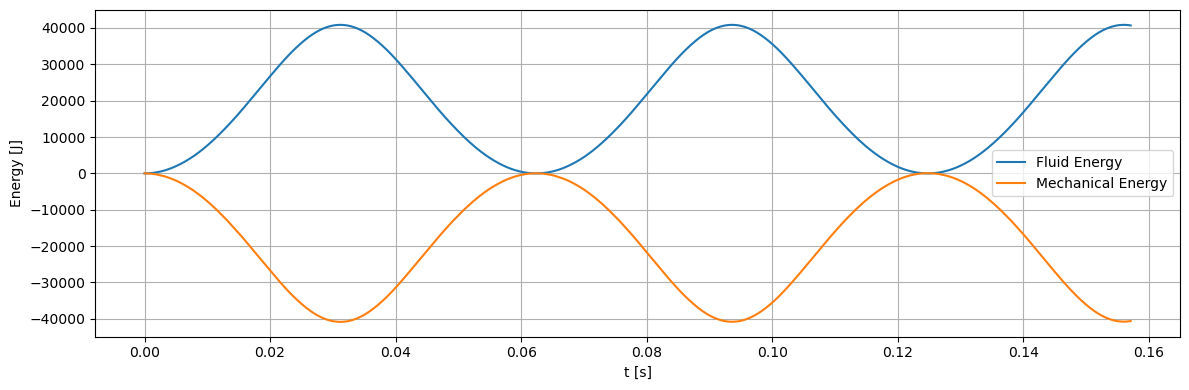

In [27]:
figure = plt.figure(figsize = (12, 4))
plt.plot(t_data, Imp_fl, label = 'Fluid Energy');
plt.plot(t_data, Em - Em[0], label = 'Mechanical Energy');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

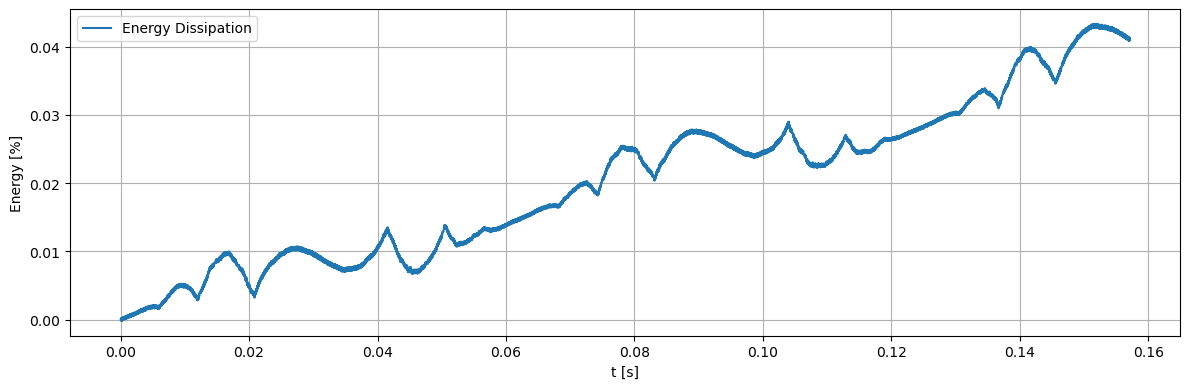

In [28]:
figure = plt.figure(figsize = (12, 4))
plt.plot(t_data, 100 * (Imp_fl + Em - Em[0])/Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

In [29]:
dmd_imp_fl = fl_nrj(predicted_pressure_accel[-1, :], predicted_dt, predicted_velocity_accel[-1, :])
dmd_Em = mech_nrj(predicted_velocity_accel[-1, :], predicted_mesh_accel[-1, :] - L0)

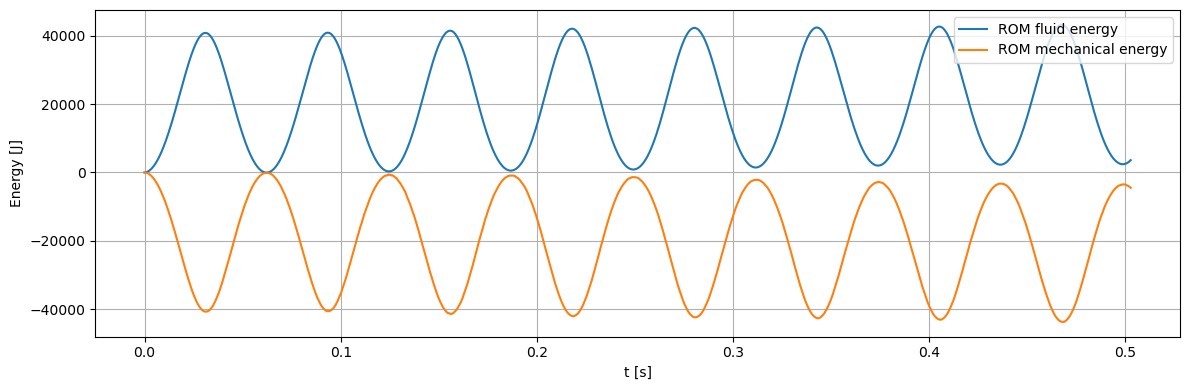

In [30]:
figure = plt.figure(figsize = (12, 4))
plt.plot(prediction_t, dmd_imp_fl, label = 'ROM fluid energy')
plt.plot(prediction_t, dmd_Em - dmd_Em[0], label = 'ROM mechanical energy')
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

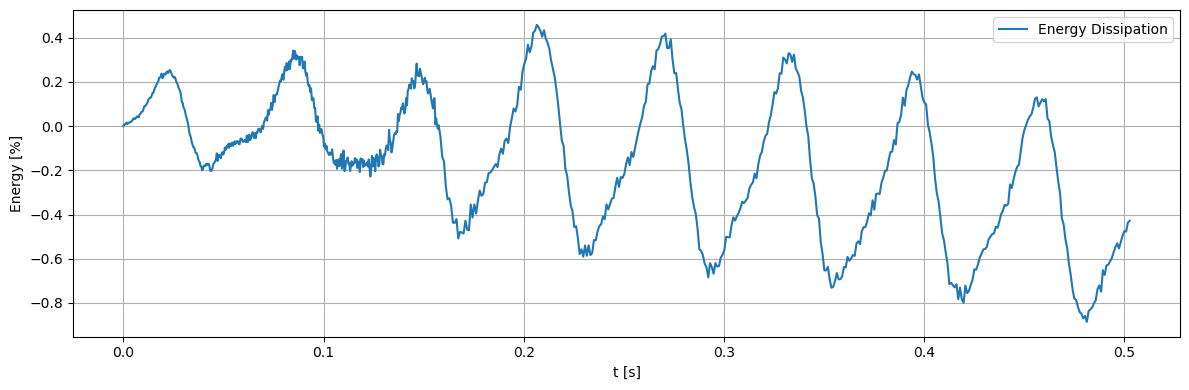

In [31]:
figure = plt.figure(figsize = (12, 4))
plt.plot(prediction_t, 100 * (dmd_imp_fl + dmd_Em - dmd_Em[0])/dmd_Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

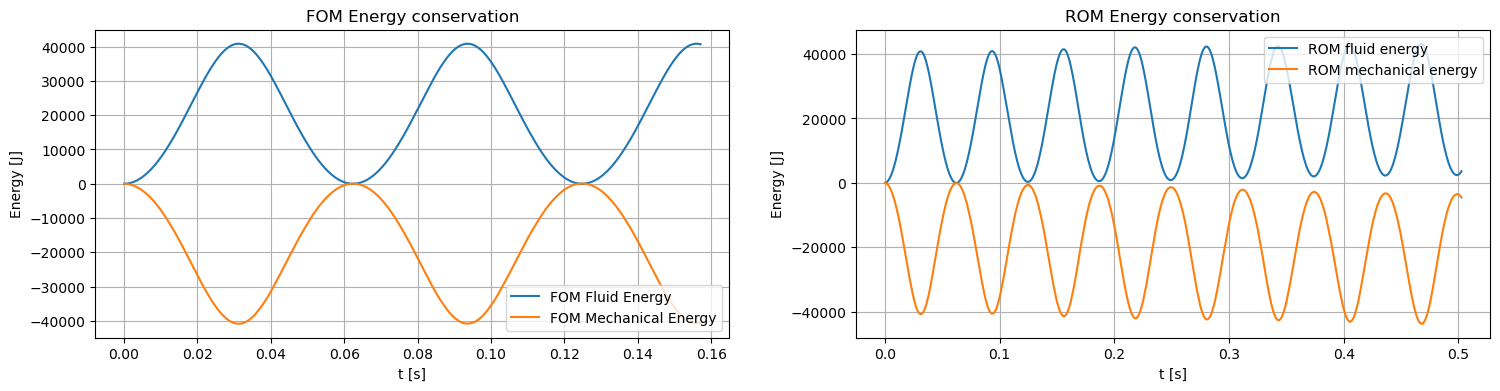

In [32]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

ax[0].plot(t_data, Imp_fl, label = 'FOM Fluid Energy');
ax[0].plot(t_data, Em - Em[0], label = 'FOM Mechanical Energy');
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("Energy [J]");
ax[0].set_title("FOM Energy conservation");
ax[0].legend();

ax[1].plot(prediction_t, dmd_imp_fl, label = 'ROM fluid energy');
ax[1].plot(prediction_t, dmd_Em - dmd_Em[0], label = 'ROM mechanical energy');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("Energy [J]");
ax[1].set_title("ROM Energy conservation");
ax[1].legend();

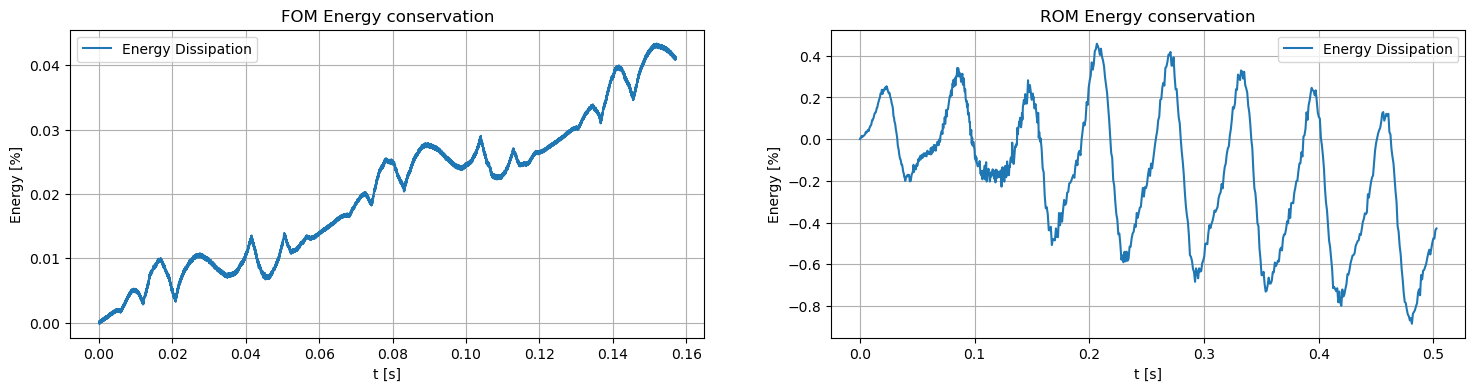

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

ax[0].plot(t_data, 100 * (Imp_fl + Em - Em[0])/Em, label = 'Energy Dissipation');
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("Energy [%]");
ax[0].legend();
ax[0].set_title("FOM Energy conservation");

ax[1].set_title("ROM Energy conservation");
ax[1].plot(prediction_t, 100 * (dmd_imp_fl + dmd_Em - dmd_Em[0])/dmd_Em, label = 'Energy Dissipation');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("Energy [%]");
ax[1].legend();

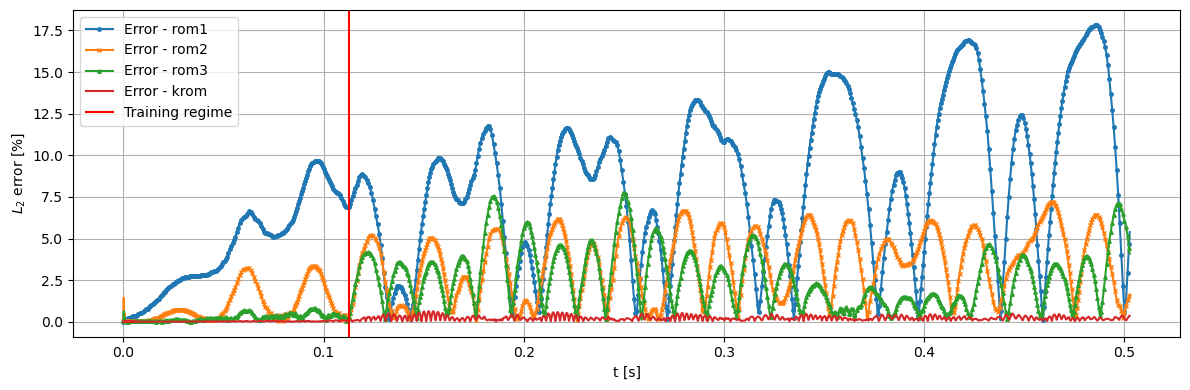

In [34]:
figure = plt.figure(figsize = (12, 4))

reference = np.vstack((fl_pressure_long, fl_velocity_long, moving_mesh_long, s_accel_long))
pred_t = t_data_long.copy()
prediction = np.real(drom2.predict(pred_t, t1 = t[0], stabilize=satbilize_))
prediction3 = np.real(drom3.predict(pred_t, t1 = t[0], stabilize=satbilize_))
prediction2 = np.real(drom.predict(pred_t, t1 = t[0], stabilize=satbilize_))
k_prediction = np.real(kdrom.predict(pred_t, t1 = t[0] - dt, stabilize=satbilize_))

errors = np.linalg.norm(prediction-reference[:-251, :], axis =0)/np.linalg.norm(reference[:-251, :], axis =0)
errors3 = np.linalg.norm(prediction3-reference, axis =0)/np.linalg.norm(reference, axis =0)
errors2 = np.linalg.norm(prediction2-reference[:-1, :], axis =0)/np.linalg.norm(reference[:-1, :], axis =0)
k_errors = np.linalg.norm(k_prediction-reference, axis =0)/np.linalg.norm(reference, axis =0)

plt.plot(pred_t, 100 * errors, 'o-', markevery = 69, markersize = 2.5, label = 'Error - rom1');
plt.plot(pred_t, 100 * errors2, 'x-', markevery = 69, markersize = 2.5, label = 'Error - rom2');
plt.plot(pred_t, 100 * errors3, '^-',  markevery = 69, markersize = 2.5, label = 'Error - rom3');
plt.plot(pred_t, 100 * k_errors, '-',  markevery = 69, markersize = 2.5, label = 'Error - krom');
plt.axvline(x = train_t[-1], color = 'red', label = 'Training regime');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("$L_2$ error [%]");
plt.legend();
plt.tight_layout();

**We test for new initial data**

In [35]:
folder_name = "../../fsi_piston/Results/export_lin/"
new_pist_pressure = np.load(folder_name+"pist_pressure.npy")
nnt = new_pist_pressure.shape[0]
new_fl_pressure = np.load(folder_name+"fl_pressure.npy")
new_fl_rho_e = np.load(folder_name+"fl_rho_e.npy")
new_fl_rho_v = np.load(folder_name+"fl_rho_v.npy")
new_fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
new_fl_rho = np.load(folder_name+"fl_rho.npy")
new_moving_mesh = np.load(folder_name+"moving_mesh.npy")
new_delta_t = np.load(folder_name+"delta_t.npy")
new_fl_energy = new_fl_rho_e/new_fl_rho
new_fl_velocity = new_fl_rho_v/new_fl_rho
new_s_accel = np.load(folder_name+"sol_accel.npy")
new_Ec = np.load(folder_name+"Ec.npy")
new_Em = np.load(folder_name+"Em.npy")
new_Ep = np.load(folder_name+"Ep.npy")
new_Imp_fl = np.load(folder_name+"Imp_fl.npy")

new_t_data = np.cumsum(new_delta_t)
new_nt = new_fl_pressure.shape[1]

new_init = np.vstack((new_fl_pressure[:, [0]], new_fl_velocity[:, [0]], new_moving_mesh[:, [0]], new_s_accel[[0]].reshape((-1, 1))))

new_init = (new_init/kdrom.snap_norms[:, np.newaxis]).ravel()

new_pred_X = np.real(kdrom.predict(prediction_t, t1 = t[0], stabilize = True, method = 1, init = new_init))


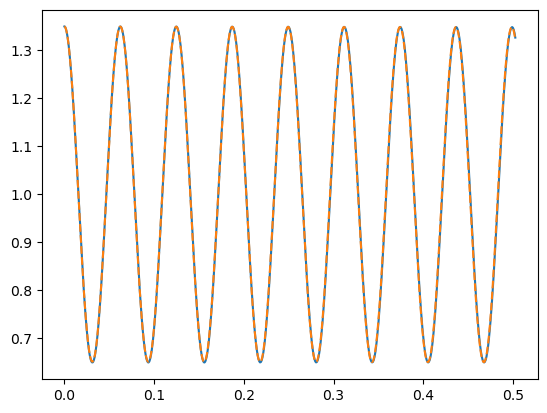

In [36]:
plt.plot(prediction_t, new_pred_X[749, :]);
plt.plot(new_t_data, new_moving_mesh[-1, :], '--');

## Display

In [37]:
"""
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize = (12, 6))

x = mesh[:, 0]
line, = ax.plot(x, pressure[:, 0], label = "Pressure HF Solution");
thresh = pressure[:, 0].min()*.9
line2, = ax.plot(x, thresh * np.ones(x.shape[0]), 'k', linewidth = 3,);
line3, = ax.plot(mesh[-1, 0] * np.ones(50), np.linspace(thresh * .96, thresh * 1.04, 50), 'k', linewidth = 3,);
line4, = ax.plot(x[::20], thresh * np.ones(x[::20].shape[0]), 'kx', linewidth = 3, markersize = 12);
line5, = ax.plot(x, pressure[:, 0], label = "Predicted DMD Pressure");
plt.xlabel("x")
plt.ylabel("Pressure")

def animate(i):
    
    plt.title(f"t = {t[i]:.5f} s");
    
    length = max(pressure[:, i+1].max(), predicted_pressure_accel[:, i+1].max())  - min(pressure[:, i+1].min(), predicted_pressure_accel[:, i+1].min())
    thresh = min(pressure[:, i+1].min(), predicted_pressure_accel[:, i+1].min()) - .1 * length

    ax.set_ylim(top = max(pressure[:, i+1].max(), predicted_pressure_accel[:, i+1].max()) + .1 * length, bottom = thresh);

    line.set_xdata(mesh[:, i+1])  ;
    line.set_ydata(pressure[:, i+1]) ;
    
    line2.set_xdata(mesh[:, i+1])  ;
    line2.set_ydata(thresh + .1 * length) ;
    
    line3.set_xdata(mesh[-1, i+1]) ;
    line3.set_ydata(np.linspace(thresh, thresh + length *  .2, 50));
    
    line4.set_xdata(mesh[:, i+1][::20]) ; 
    line4.set_ydata(thresh + .1 * length);
    
    line5.set_xdata(predicted_mesh_accel[:, i+1])  ;
    line5.set_ydata(predicted_pressure_accel[:, i+1]);
    return line, line2, line3, line4, line5

plt.legend();
ani = animation.FuncAnimation(
    fig, animate, interval=110, blit=False, save_count=mesh.shape[1]-1);

# save the animation - Uncomment to save the animation video (expensive and probably requires ffmpeg)
#ani.save("Pressure_in_Fluid.mp4")
""";

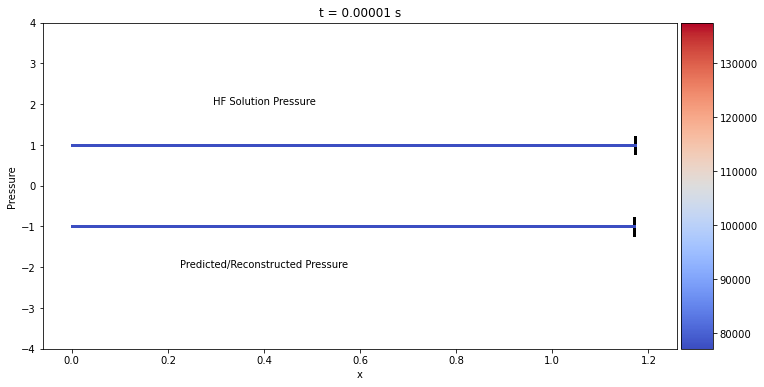

In [31]:
"""
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

n_cut = 9

fig, ax = plt.subplots(figsize = (12, 6))

pres_max = np.abs(pressure).max()
pres_min = np.abs(pressure).min()

norm = plt.cm.colors.Normalize(vmin=pres_min, vmax=pres_max)
colors = plt.cm.coolwarm(norm(pressure[::n_cut, :]))
colors2 = plt.cm.coolwarm(norm(predicted_pressure_accel[::n_cut, :]))

x = mesh[:, 0][::n_cut]
x2 = predicted_mesh_accel[:, 0][::n_cut]

for j in range(len(x)-1):
    line2, = ax.plot([x[j], x[j+1]], [1, 1], linewidth = 3, color = colors[j, 0, :],);
    line5, = ax.plot([x2[j], x2[j+1]], [-1, -1], linewidth = 3, color = colors2[j, 0, :],);

line3, = ax.plot(mesh[-1, 0] * np.ones(2), np.linspace(.96, 1.04, 2), 'k', linewidth = 3,);
line4, = ax.plot(predicted_mesh_accel[-1, 0] * np.ones(2), np.linspace(-.96, -1.04, 2), 'k', linewidth = 3,);

plt.xlabel("x")
plt.ylabel("Pressure")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cmap = mpl.cm.coolwarm

ax.text(.4, 2, "HF Solution Pressure", ha = "center")
ax.text(.4, -2, "Predicted/Reconstructed Pressure", ha = "center")

def animate(i):
    x = mesh[:, i][::n_cut]
    x2 = predicted_mesh_accel[:, i][::n_cut]

    ax.set_title(f"t = {t[i]:.5f} s");
    ax.set_ylim(top = 4, bottom = -4);

    if i>0:
        ax.plot(mesh[:, i-1][::n_cut], np.ones(x.shape[0]),  'w', linewidth = 3,);
        ax.plot(predicted_mesh_accel[:, i-1][::n_cut], -np.ones(x.shape[0]),  'w', linewidth = 3,);

    for j in range(len(x)-1):
        line2, = ax.plot([x[j], x[j+1]], [1, 1], linewidth = 3, color = colors[j, i, :]);
        line5, = ax.plot([x2[j], x2[j+1]], [-1, -1], linewidth = 3, color = colors2[j, i, :]);

    line3.set_xdata(x[-1]) ;
    line3.set_ydata(np.linspace(.8, 1.2, 2));

    line4.set_xdata(x2[-1]) ;
    line4.set_ydata(np.linspace(-.8, -1.2, 2));

    return line2, line3, line4, line5

cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation="vertical")

ani = animation.FuncAnimation(
    fig, animate, interval=95, blit=True, save_count=mesh.shape[1]);

# save the animation - Uncomment to save the animation video (expensive and probably requires ffmpeg)
# ani.save("Pressure_in_Fluid_2.mp4")
""";

**DMD modes (Regularization)**

When dealing with ill-conditioned input matrices regularization methods should be used to deal with the least square problem; we are using the well-known Tikhonov regularization in our case, i.e minimizing 
$$ \|\pmb A \pmb X - \pmb Y\|^2 + \lambda \|\pmb A\|^2 \|\pmb X\|^2$$
instead of 
$$ \|\pmb A \pmb X - \pmb Y\|^2$$

Here we use ```tikhonov = 1e-9``` instead of the default ```tikhonov = 0``` (no regularization)

PS : We first change the timestep for training snapshots to better highlight the ill-conditioning problem

In [38]:
# Choose number of equally spaced timesteps 
ntt = 510
dt = (t_data[-1] - t_data[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
t = np.linspace(t_data[0], t_data[-1], ntt)
pressure = si.griddata(t_data, fl_pressure.T, t, method='nearest').T
velocity = si.griddata(t_data, fl_velocity.T, t, method='nearest').T
mesh = si.griddata(t_data, moving_mesh.T, t, method='nearest').T
sol_accel = si.griddata(t_data, s_accel.T, t, method='nearest').T
domain = np.linspace(0, L, nx)

Coeff = .8

# Training data (considering moving mesh AND mass acceleration)
XY_DATA_3 = np.concatenate((pressure[:, :int(ntt * Coeff)], velocity[:, :int(ntt * Coeff)], 
                          mesh[:, :int(ntt * Coeff)], sol_accel[:int(ntt * Coeff)][np.newaxis, :]))
X3 = XY_DATA_3[:, :-1]
Y3 = XY_DATA_3[:, 1::]

In [39]:
rank = np.linspace(10, X3.shape[1], 10).astype(int)
cond_ = np.zeros((len(rank), 2))

j=0
for i in rank:
    rank_ = i
    
    dmd3c = DMD()
    drom3c = ROM(dmd3c)
    drom3c.decompose(X3,  Y = Y3, dt = dt, rank = rank_, sorting = "abs", tikhonov=1e-8)
    
    dmd3 = DMD()
    drom3 = ROM(dmd3)
    drom3.decompose(X3,  Y = Y3, dt = dt, rank = rank_, sorting = "abs", tikhonov=0)
    
    cond_[j, 0] = np.linalg.cond(drom3c.model.A_tilde)
    cond_[j, 1] = np.linalg.cond(drom3.model.A_tilde)
    j+= 1

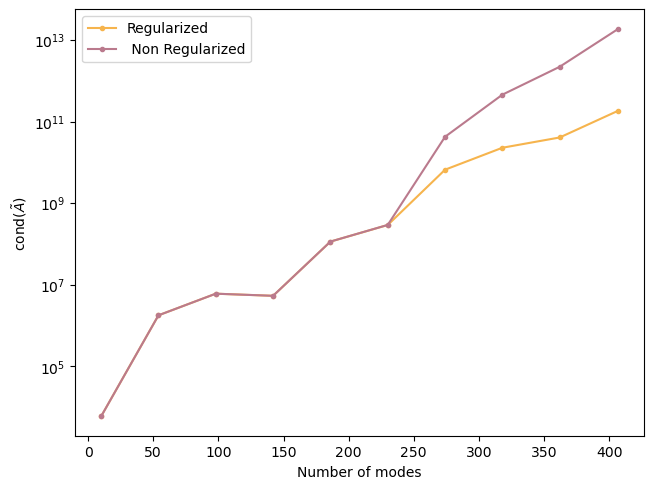

In [40]:
fig = plt.figure();
it = plt.semilogy(rank, cond_[:, 0], '.-', color = "#f6b44d", label = "Regularized");
it = plt.semilogy(rank, cond_[:, 1], '.-', color = "#ba7a8d", label = " Non Regularized");

plt.tight_layout();
plt.ylabel(r"cond($\tilde{A}$)", fontsize = 10);
plt.xlabel("Number of modes");
plt.legend();

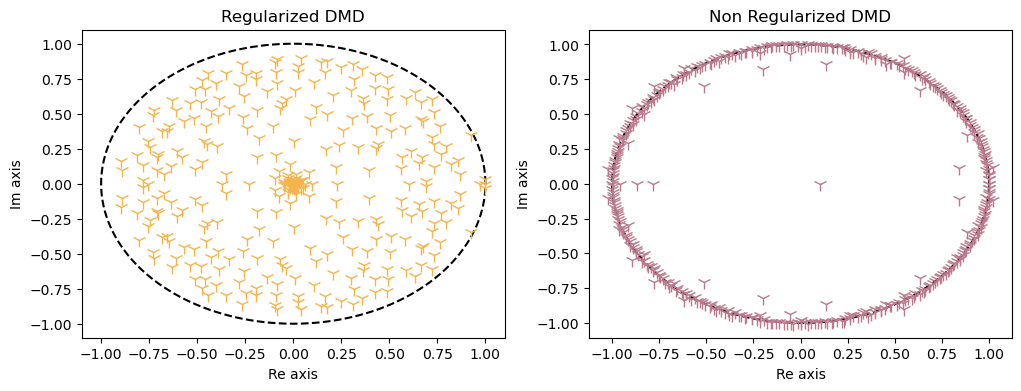

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].set_xlabel("Re axis");
ax[0].set_ylabel("Im axis");
ax[1].set_xlabel("Re axis");
ax[1].set_ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
ax[0].plot(np.cos(theta), np.sin(theta), "k--");
ax[1].plot(np.cos(theta), np.sin(theta), "k--");

ax[0].set_title("Regularized DMD");
ax[0].plot(np.real(drom3c.model.lambd), np.imag(drom3c.model.lambd), '1', color = '#f6b44d',  markersize = 10);
ax[1].set_title("Non Regularized DMD");
ax[1].plot(np.real(drom3.model.lambd), np.imag(drom3.model.lambd), '1', color = u'#ba7a8d', markersize = 10);

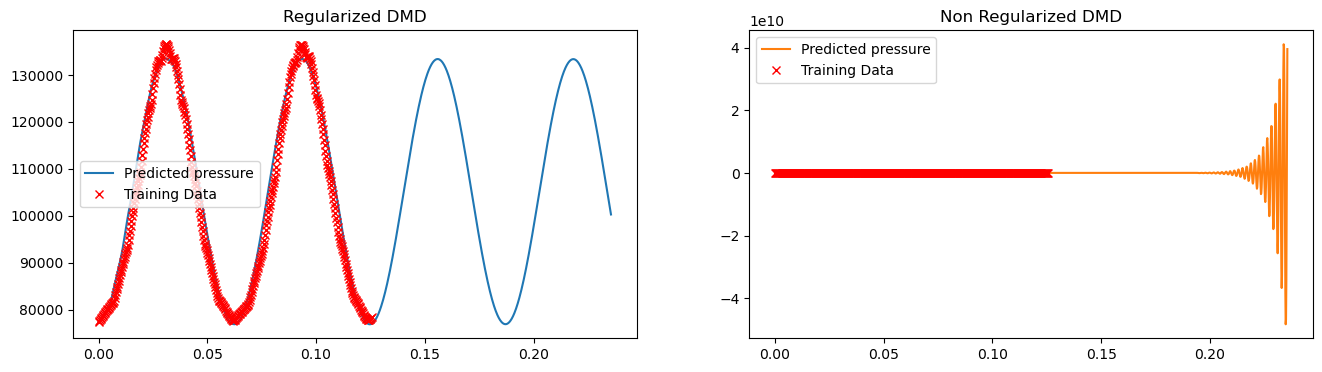

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
prediction_t = np.concatenate((t, np.linspace(t[-1] + dt, 1.5 * t[-1], int(ntt))))
predicted_X3c = np.real(drom3c.predict(prediction_t, t1 = t[0]))
predicted_X3 = np.real(drom3.predict(prediction_t, t1 = t[0], stabilize=False))

pred_presc = predicted_X3c[:nx, :]
pred_pres = predicted_X3[:nx, :]

ax[0].plot(prediction_t, pred_presc[-1, :], '-', label = "Predicted pressure");
ax[0].plot(t[: int(ntt * Coeff)], pressure[-1, :int(ntt * Coeff)], 'xr', label = "Training Data");

ax[1].plot(prediction_t, pred_pres[-1, :], '-', color =  u'#ff7f0e', label = "Predicted pressure");
ax[1].plot(t[: int(ntt * Coeff)], pressure[-1, :int(ntt * Coeff)], 'xr', label = "Training Data");

ax[0].set_title("Regularized DMD");
ax[1].set_title("Non Regularized DMD");
ax[0].legend();
ax[1].legend();

--------------------------------------------------------------------------------------------------------------------------------------------

## Non linear spring

We use now a non linear model, parametrized by $k$ the spring stiffeness and $\mu$ for the non linear term:

$m \ddot u = K (L_s(t) - L_{s0}) + \mu (L_s(t) - L_{s0})^3 + A p(t)$

where $\mu = \frac{6 * K}{u_0}$

---------------------------------------------------------------------------------------------------------

**Load the data** -----------------------------------------------------------------------------------------------------------

In [43]:
case = 6 # 6 if mu_coeff = 6 case; 2 if mu_coeff = 2 
if case == 6:
    folder_name = "../DATA/Fsi/nonlin_Fsi_Results/"
    mu_coeff = 6.
else:
    folder_name = "../DATA/Fsi/nonlin_Fsi_Results_coeff_2/"
    mu_coeff = 2.

nln_pist_pressure = np.load(folder_name+"nln_pist_pressure.npy")
nln_nnt = nln_pist_pressure.shape[0]
nln_fl_pressure = np.load(folder_name+"nln_fl_pressure.npy")
nln_fl_rho_e = np.load(folder_name+"nln_fl_rho_e.npy")
nln_fl_rho_v = np.load(folder_name+"nln_fl_rho_v.npy")
nln_fl_velocity_end = np.load(folder_name+"nln_fl_velocity_end.npy")
nln_fl_rho = np.load(folder_name+"nln_fl_rho.npy")
nln_moving_mesh = np.load(folder_name+"nln_moving_mesh.npy")
nln_delta_t = np.load(folder_name+"nln_delta_t.npy")
nln_s_accel = np.load(folder_name+"nln_sol_accel.npy")
nln_fl_energy = np.load(folder_name+"nln_fl_energy.npy")
nln_fl_velocity = np.load(folder_name+"nln_fl_velocity.npy")
nln_fl_velocity_end = np.load(folder_name+"nln_fl_velocity_end.npy")
nln_Ec = np.load(folder_name+"nln_Ec.npy")
nln_Em = np.load(folder_name+"nln_Em.npy")
nln_Ep = np.load(folder_name+"nln_Ep.npy")
nln_Imp_fl = np.load(folder_name+"nln_Imp_fl.npy")

nln_t_data = np.cumsum(nln_delta_t)
nln_nt = nln_fl_pressure.shape[1]

In [44]:
"""
case = 6 # 6 if mu_coeff = 6 case; 2 if mu_coeff = 2 
if case == 6:
    folder_name = "../DATA/Fsi/nonlin_Fsi_Results/"
    mu_coeff = 6.
else:
    folder_name = "../DATA/Fsi/nonlin_Fsi_Results_coeff_2/"
    mu_coeff = 2.

folder_name= "../DATA/Fsi/res_longer_time_nln/"
nln_pist_pressure = np.load(folder_name+"pist_pressure.npy")
nln_nnt = nln_pist_pressure.shape[0]
nln_fl_pressure = np.load(folder_name+"fl_pressure.npy")
nln_fl_rho_e = np.load(folder_name+"fl_rho_e.npy")
nln_fl_rho_v = np.load(folder_name+"fl_rho_v.npy")
nln_fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
nln_fl_rho = np.load(folder_name+"fl_rho.npy")
nln_moving_mesh = np.load(folder_name+"moving_mesh.npy")
nln_delta_t = np.load(folder_name+"delta_t.npy")
nln_s_accel = np.load(folder_name+"sol_accel.npy")
nln_fl_energy = np.load(folder_name+"fl_energy.npy")
nln_fl_velocity = np.load(folder_name+"fl_velocity.npy")
nln_fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
nln_Ec = np.load(folder_name+"Ec.npy")
nln_Em = np.load(folder_name+"Em.npy")
nln_Ep = np.load(folder_name+"Ep.npy")
nln_Imp_fl = np.load(folder_name+"Imp_fl.npy")

nln_t_data = np.cumsum(nln_delta_t)
nln_nt = nln_fl_pressure.shape[1]
""";

--------------------------------------------------------------------------------------------------

In [45]:
nln_force = mass * nln_s_accel - nln_pist_pressure
force = mass * s_accel - pist_pressure

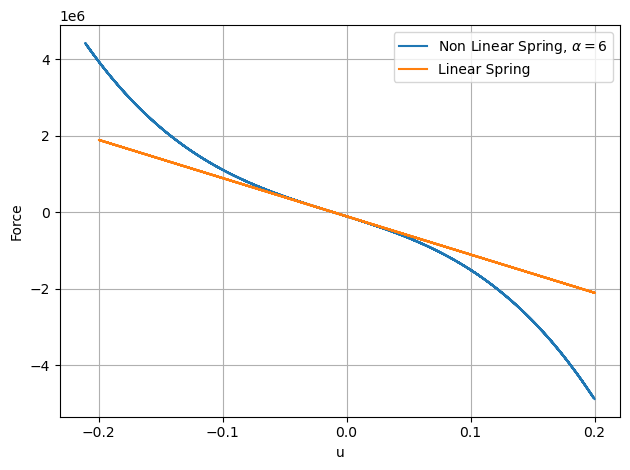

In [46]:
plt.plot(nln_moving_mesh[-1, :] - L0, nln_force, label=r"Non Linear Spring, $\alpha = 6$")
plt.plot(moving_mesh[-1, :] - L0, force, label="Linear Spring")
plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.legend();
plt.tight_layout();

In [47]:
# Choose number of equally spaced timesteps 
nln_T = 3.5 # ~ Number of modes in data
n_snap = 310 # Number of snapshots in the train data
frac = 3.1 # ~ Number of time periods in the train data
nln_ntt = int(n_snap /(frac/nln_T)) # Number of snapshots in the test+train data
nln_dt = (nln_t_data[-1] - nln_t_data[0]) / (nln_ntt - 1) # New (fixed) time step

# Interpolating original data to the new timesteps
nln_t = np.linspace(nln_t_data[0], nln_t_data[-1], nln_ntt)
nln_pressure = si.griddata(nln_t_data, nln_fl_pressure.T, nln_t, method='nearest').T
nln_velocity = si.griddata(nln_t_data, nln_fl_velocity.T, nln_t, method='nearest').T
nln_mesh = si.griddata(nln_t_data, nln_moving_mesh.T, nln_t, method='nearest').T
nln_sol_accel = si.griddata(nln_t_data, nln_s_accel.T, nln_t, method='nearest').T

In [48]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/nln_T

# Training data (considering moving mesh)
train_nln_pressure = nln_pressure[:, :int(nln_ntt * Coeff)]
train_nln_velocity = nln_velocity[:, :int(nln_ntt * Coeff)]
train_nln_mesh = nln_mesh[:, :int(nln_ntt * Coeff)]
train_nln_sol_accel = nln_sol_accel[:int(nln_ntt * Coeff)][np.newaxis, :]
train_nln_t = nln_t[:int(nln_ntt * Coeff)]

test_nln_pressure = nln_pressure[:, int(nln_ntt * Coeff)::]
test_nln_velocity = nln_velocity[:, int(nln_ntt * Coeff)::]
test_nln_mesh = nln_mesh[:, int(nln_ntt * Coeff)::]
test_nln_sol_accel = nln_sol_accel[int(nln_ntt * Coeff)::][np.newaxis, :]
test_nln_t = nln_t[int(nln_ntt * Coeff)::]

train_nln_data = np.concatenate((train_nln_pressure, train_nln_velocity, train_nln_mesh, train_nln_sol_accel))

nln_X = train_nln_data[:, :-1]
nln_Y = train_nln_data[:, 1::]

rank = 0
nln_dmd = DMD()
nln_drom = ROM(nln_dmd)
nln_drom.decompose(nln_X,  Y = nln_Y, dt = nln_dt, rank = rank, normalize=True, tikhonov =None)



train_nln_data_nomesh = np.concatenate((train_nln_pressure, train_nln_velocity,))

nln_X_nomesh = train_nln_data_nomesh[:, :-1]
nln_Y_nomesh = train_nln_data_nomesh[:, 1::]
rank = 0
nln_dmd_nomesh = DMD()
nln_drom_nomesh = ROM(nln_dmd_nomesh)
nln_drom_nomesh.decompose(nln_X_nomesh,  Y = nln_Y_nomesh, dt = nln_dt, rank = rank, normalize=True,)


train_nln_data_no_accel = np.concatenate((train_nln_pressure, train_nln_velocity, train_nln_mesh,))

nln_X_no_accel = train_nln_data_no_accel[:, :-1]
nln_Y_no_accel = train_nln_data_no_accel[:, 1::]

rank = 0
nln_dmd_no_accel = DMD()
nln_drom_no_accel = ROM(nln_dmd_no_accel)
nln_drom_no_accel.decompose(nln_X_no_accel,  Y = nln_Y_no_accel, dt = nln_dt, rank = rank, normalize=True,)



In [49]:
rank = 0
nln_kdmd = KERDMD()
nln_kdrom = ROM(nln_kdmd)
nln_kdrom.decompose(nln_X,  Y = nln_Y, dt = nln_dt, rank =rank, normalize=True, center = False, kernel = 'poly', 
                    sig = .9, p = 2)

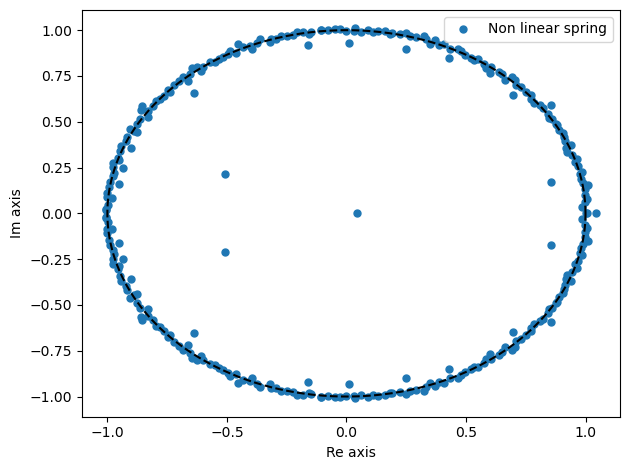

In [50]:
plt.plot(np.real(nln_drom.model.lambd), np.imag(nln_drom.model.lambd), '.', markersize = 10, label = "Non linear spring");
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.legend();
plt.tight_layout();

In [52]:
nln_prediction_t = np.concatenate((nln_t, np.linspace(nln_t[-1] + nln_dt, 3.2 * nln_t[-1], int(nln_ntt))))
nln_predicted_X = np.real(nln_drom.predict(nln_prediction_t, t1 = nln_t[0], stabilize = True,method =0))
nln_predicted_X_nomesh = np.real(nln_drom_nomesh.predict(nln_prediction_t, t1 = nln_t[0], stabilize = True))
nln_predicted_X_no_accel = np.real(nln_drom_no_accel.predict(nln_prediction_t, t1 = nln_t[0], stabilize = True))

nln_predicted_pressure = nln_predicted_X[:nx, :]
nln_predicted_velocity = nln_predicted_X[nx:2*nx, :]
nln_predicted_disp = nln_predicted_X[2*nx:3*nx, :]

nln_predicted_pressure_nomesh = nln_predicted_X_nomesh[:nx, :]
nln_predicted_velocity_nomesh = nln_predicted_X_nomesh[nx:2*nx, :]

nln_predicted_pressure_no_accel = nln_predicted_X_no_accel[:nx, :]
nln_predicted_velocity_no_accel = nln_predicted_X_no_accel[nx:2*nx, :]
nln_predicted_disp_no_accel = nln_predicted_X_no_accel[2*nx:3*nx, :]

In [51]:
cutoff = int(1.*len(t_data_long_nln))

In [54]:
nln_k_X = np.real(nln_kdrom.predict(nln_prediction_t, t1 = nln_t[0] - nln_dt, stabilize = True))

nln_k_pres = nln_k_X[:nx, :]
nln_k_veloc = nln_k_X[nx:2*nx, :]
nln_k_disp = nln_k_X[2*nx:3*nx, :]

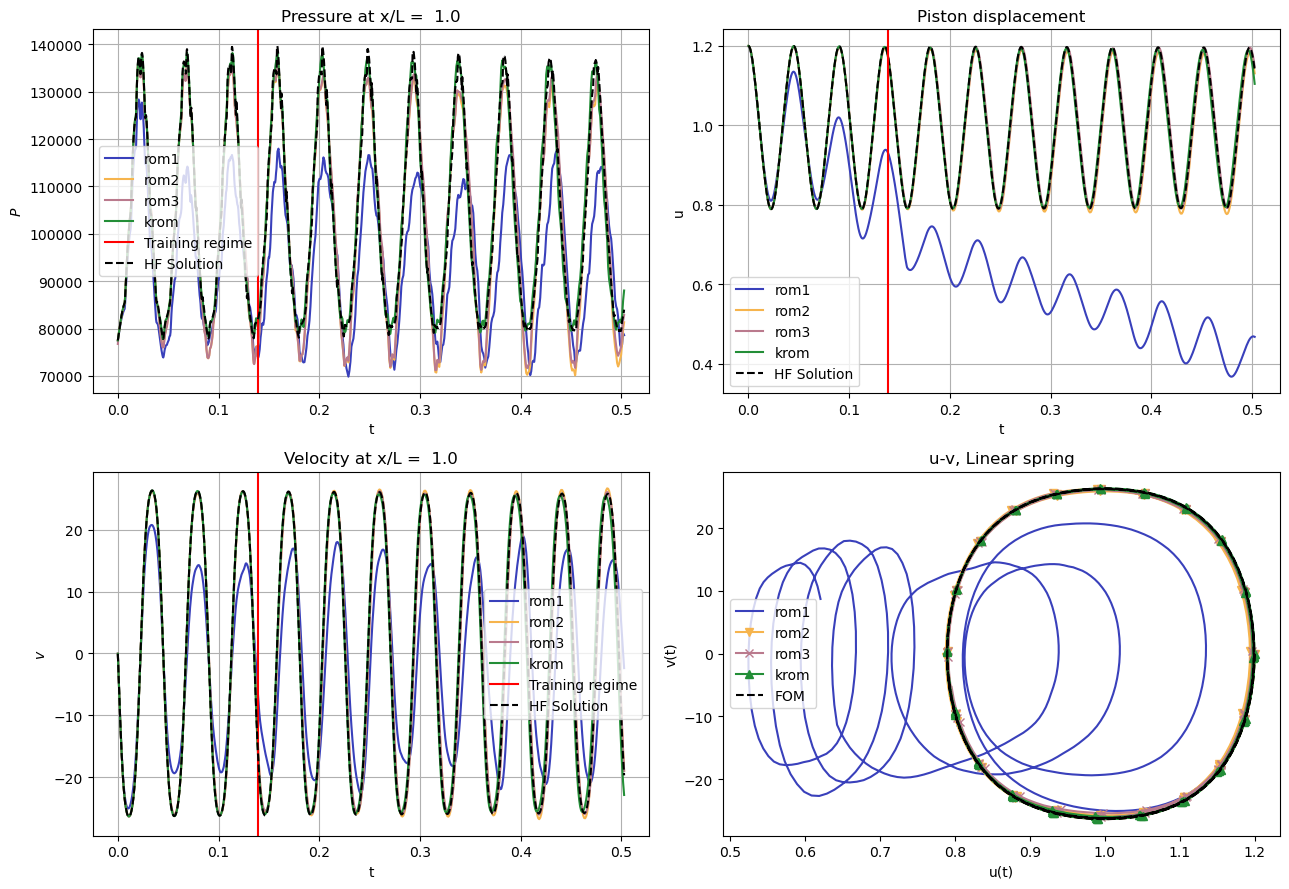

In [55]:
x_n = 1
fig, ax = plt.subplots(2, 2, figsize = (13., 9.))

ax[0, 0].plot(nln_prediction_t, nln_predicted_pressure_nomesh[-x_n, :], '-', color ="#3940bb", label = "rom1")
ax[0, 0].plot(nln_prediction_t, nln_predicted_pressure_no_accel[-x_n, :], '-', color ="#f6b44d", label = "rom2")
ax[0, 0].plot(nln_prediction_t, nln_predicted_pressure[-x_n, :], '-', color = "#ba7a8d", label = "rom3")
ax[0, 0].plot(nln_prediction_t, nln_k_pres[-x_n, :], '-', color = "#238E37", label = "krom")
ax[0, 0].axvline(train_nln_t[-1], color = 'red', label = 'Training regime')
ax[0, 0].plot(t_data_long_nln[:cutoff], fl_pressure_long_nln[-x_n, :cutoff], '--k', label = "HF Solution");
ax[0, 0].legend();
ax[0, 0].grid();

ax[0, 0].set_xlabel("t");
ax[0, 0].set_ylabel("$P$");
ax[0, 0].set_title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));


ax[0, 1].plot(nln_prediction_t, np.cumsum(nln_predicted_velocity_nomesh[-1, :]*nln_dt)+1.2, color ="#3940bb", label = "rom1");
ax[0, 1].plot(nln_prediction_t, nln_predicted_disp_no_accel[-1, :], '-', color ="#f6b44d",label = "rom2");
ax[0, 1].plot(nln_prediction_t, nln_predicted_disp[-1, :], '-', color = "#ba7a8d",label = "rom3");
ax[0, 1].plot(nln_prediction_t, nln_k_disp[-1, :], '-', color = "#238E37", label = "krom");
ax[0, 1].plot(t_data_long_nln[:cutoff], moving_mesh_long_nln[-1, :cutoff], '--k', label = "HF Solution");
ax[0, 1].legend();
ax[0, 1].grid();
ax[0, 1].set_title("Piston displacement");
ax[0, 1].set_xlabel("t");
ax[0, 1].set_ylabel("u");
ax[0, 1].axvline(train_nln_t[-1], color = 'red', label = 'Training regime')



ax[1, 0].plot(nln_prediction_t, nln_predicted_velocity_nomesh[-x_n, :], '-', color ="#3940bb", label = "rom1")
ax[1, 0].plot(nln_prediction_t, nln_predicted_velocity_no_accel[-x_n, :], '-',color ="#f6b44d", label = "rom2")
ax[1, 0].plot(nln_prediction_t, nln_predicted_velocity[-x_n, :], '-', color = "#ba7a8d", label = "rom3")
ax[1, 0].plot(nln_prediction_t, nln_k_veloc[-x_n, :], '-',color = "#238E37",  label = "krom")
ax[1, 0].axvline(train_nln_t[-1], color = 'red', label = 'Training regime')
ax[1, 0].plot(t_data_long_nln[:cutoff], fl_velocity_long_nln[-x_n, :cutoff], '--k', label = "HF Solution");
ax[1, 0].legend();
ax[1, 0].grid();

ax[1, 0].set_xlabel("t");
ax[1, 0].set_ylabel("$v$");
ax[1, 0].set_title("Velocity at x/L =  " + str(L * (nx - x_n + 1)/nx));



ax[1, 1].plot(np.cumsum(nln_predicted_velocity_nomesh[-1, :t.shape[0]]*nln_dt)+1.2, nln_predicted_velocity_nomesh[-1, :t.shape[0]], color ="#3940bb", label = 'rom1');
ax[1, 1].plot(nln_predicted_disp_no_accel[-1, :nln_t.shape[0]], nln_predicted_velocity_no_accel[-1, :nln_t.shape[0]], 'v-', markevery = 5,color ="#f6b44d", label = 'rom2');
ax[1, 1].plot(nln_predicted_disp[-1, :nln_t.shape[0]], nln_predicted_velocity[-1, :nln_t.shape[0]], '-x', markevery = 5,color = "#ba7a8d", label = 'rom3');
ax[1, 1].plot(nln_k_disp[-1, :nln_t.shape[0]], nln_k_veloc[-1, :nln_t.shape[0]], '-^', markevery = 5,color = "#238E37", label = 'krom');
ax[1, 1].plot(nln_moving_mesh[-1, :], nln_fl_velocity_end[-1, :], '--k', label = 'FOM');
ax[1, 1].legend();
ax[1, 1].set_xlabel("u(t)")
ax[1, 1].set_ylabel("v(t)")
ax[1, 1].set_title(r"u-v, Linear spring");

plt.tight_layout();



In [56]:
nlpredicted_X = np.real(nln_drom_nomesh.predict(t_data_long_nln, t1 = nln_t[0], stabilize=satbilize_))
nlpredicted_X2 = np.real(nln_drom_no_accel.predict(t_data_long_nln, t1 = nln_t[0], stabilize=satbilize_))
nlpredicted_X3 = np.real(nln_drom.predict(t_data_long_nln, t1 = nln_t[0], stabilize=satbilize_,))
nlpredicted_Xk = np.real(nln_kdrom.predict(t_data_long_nln, t1 = nln_t[0] - nln_dt, stabilize=satbilize_,))

reference = fl_pressure_long_nln[:, 16430:]
predicted1 = nlpredicted_X[:250, 16430:]
predicted2 = nlpredicted_X2[:250, 16430:]
predicted3 = nlpredicted_X3[:250, 16430:]
predictedk = nlpredicted_Xk[:250, 16430:]

error1 = np.sqrt(((predicted1 - reference)**2))/reference
error2 = np.sqrt(((predicted2 - reference)**2))/reference
error3 = np.sqrt(((predicted3 - reference)**2))/reference
errork = np.sqrt(((predictedk - reference)**2))/reference

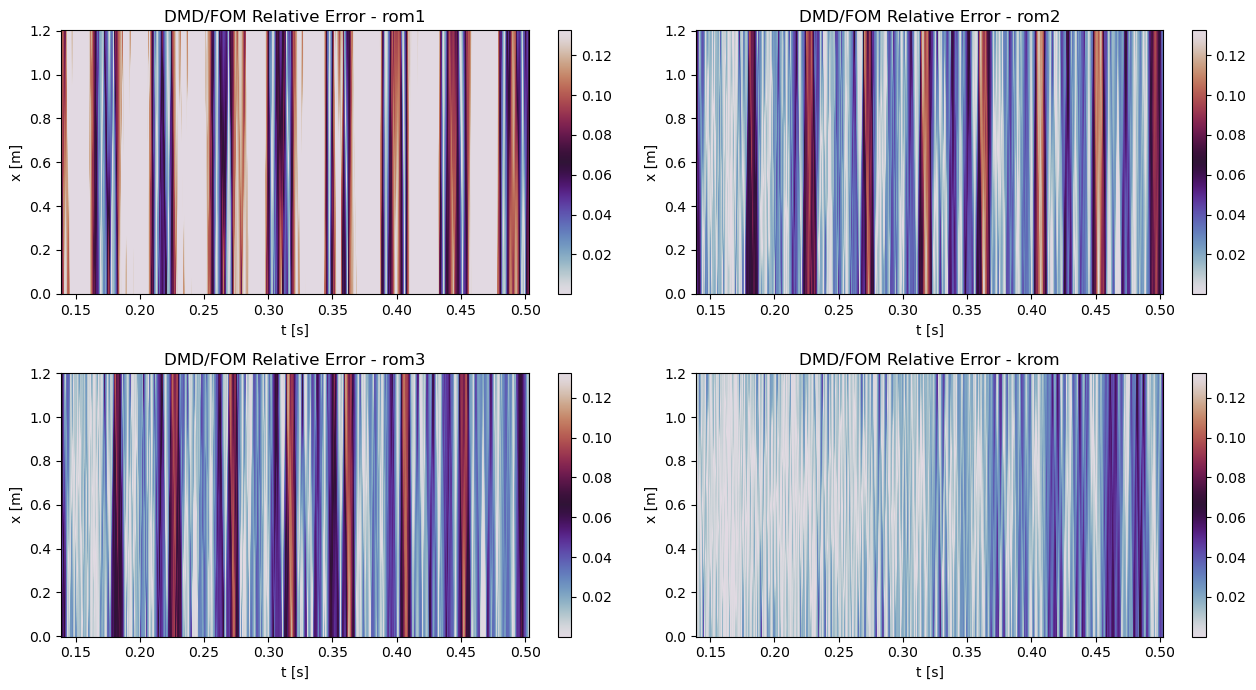

In [57]:
fig, ax = plt.subplots(2, 2, figsize = (13, 7))

x0 = t_data_long_nln[16430:]
y0 = nln_moving_mesh[:, 0]

z1 = error1
z2 = error2
z3 = error3
zk = errork

z_min1, z_max1 = z1.min(), z1.max()
z_min2, z_max2 = z2.min(), z2.max()
z_min3, z_max3 = z3.min(), z3.max()
z_mink, z_maxk = zk.min(), zk.max()
z_min0 = min([z_min1, z_min2, z_min3, z_mink])
z_max0 = max([z_max2, z_max3, z_maxk])


c1 = ax[0, 0].pcolormesh(x0, y0, z1, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)
c2 = ax[0, 1].pcolormesh(x0, y0, z2, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)
c3 = ax[1, 0].pcolormesh(x0, y0, z3, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)
ck = ax[1, 1].pcolormesh(x0, y0, zk, cmap ='twilight', vmin = z_min0, vmax = z_max0, shading = 'auto', rasterized=True)

plt.colorbar(c1, ax=ax[0, 0])
plt.colorbar(c2, ax=ax[0, 1])
plt.colorbar(c3, ax=ax[1, 0])
plt.colorbar(ck, ax=ax[1, 1])

ax[0, 0].set_title(r'DMD/FOM Relative Error - rom1')
ax[0, 1].set_title(r'DMD/FOM Relative Error - rom2')
ax[1, 0].set_title(r'DMD/FOM Relative Error - rom3')
ax[1, 1].set_title(r'DMD/FOM Relative Error - krom')

ax[0, 0].set_ylabel("x [m]")
ax[0, 0].set_xlabel("t [s]")

ax[1, 0].set_ylabel("x [m]")
ax[1, 0].set_xlabel("t [s]")

ax[0, 1].set_ylabel("x [m]")
ax[0, 1].set_xlabel("t [s]")

ax[1, 1].set_ylabel("x [m]")
ax[1, 1].set_xlabel("t [s]")

plt.tight_layout()
plt.show()



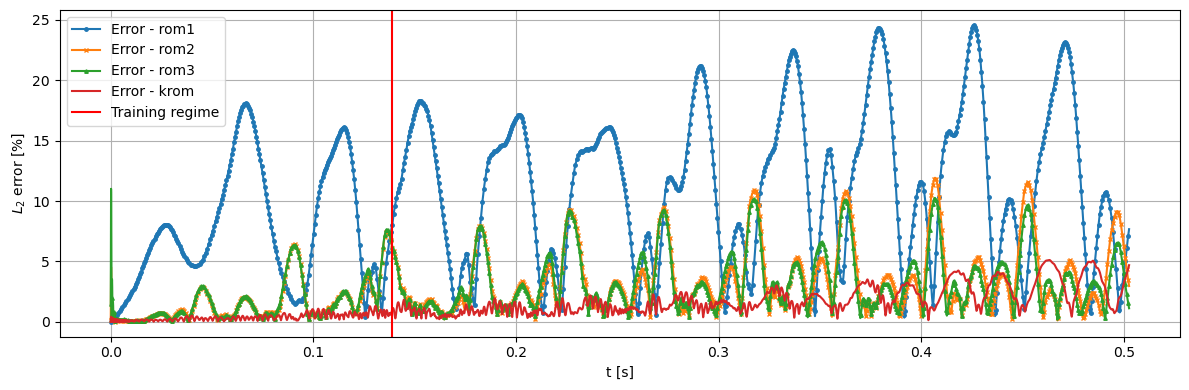

In [58]:
figure = plt.figure(figsize = (12, 4))

reference = np.vstack((fl_pressure_long_nln, fl_velocity_long_nln, moving_mesh_long_nln, s_accel_long_nln))
pred_t = t_data_long_nln.copy()
prediction = np.real(nln_drom_nomesh.predict(pred_t, t1 = nln_t[0], stabilize=satbilize_))
prediction3 = np.real(nln_drom.predict(pred_t, t1 = nln_t[0], stabilize=satbilize_))
prediction2 = np.real(nln_drom_no_accel.predict(pred_t, t1 = nln_t[0], stabilize=satbilize_))
k_prediction = np.real(nln_kdrom.predict(pred_t, t1 = nln_t[0] - nln_dt, stabilize=satbilize_))

errors = np.linalg.norm(prediction-reference[:-251, :], axis =0)/np.linalg.norm(reference[:-251, :], axis =0)
errors3 = np.linalg.norm(prediction3-reference, axis =0)/np.linalg.norm(reference, axis =0)
errors2 = np.linalg.norm(prediction2-reference[:-1, :], axis =0)/np.linalg.norm(reference[:-1, :], axis =0)
k_errors = np.linalg.norm(k_prediction-reference, axis =0)/np.linalg.norm(reference, axis =0)

plt.plot(pred_t, 100 * errors, 'o-', markevery = 69, markersize = 2.5, label = 'Error - rom1');
plt.plot(pred_t, 100 * errors2, 'x-', markevery = 69, markersize = 2.5, label = 'Error - rom2');
plt.plot(pred_t, 100 * errors3, '^-',  markevery = 69, markersize = 2.5, label = 'Error - rom3');
plt.plot(pred_t, 100 * k_errors, '-',  markevery = 69, markersize = 2.5, label = 'Error - krom');
plt.axvline(x = train_nln_t[-1], color = 'red', label = 'Training regime');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("$L_2$ error [%]");
plt.legend();
plt.tight_layout();

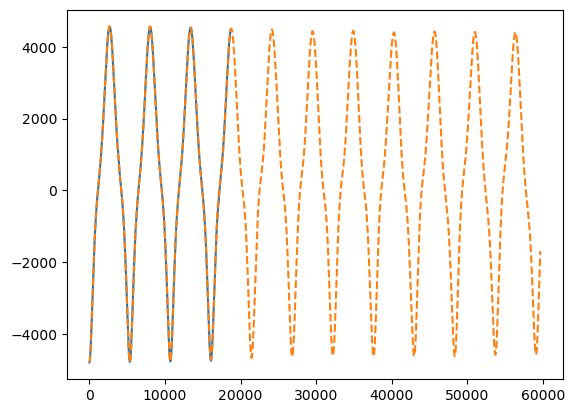

In [59]:
plt.plot(nln_s_accel);
plt.plot(k_prediction[-1, :], '--');

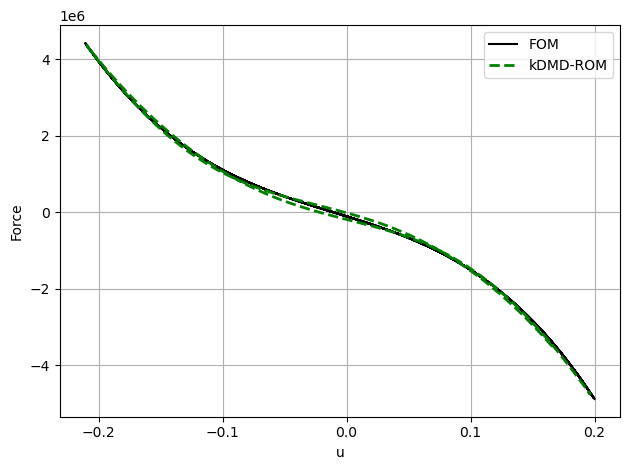

In [60]:
nln_force = mass * nln_s_accel - nln_pist_pressure

nln_force_pred = mass * k_prediction[-1, :] - k_prediction[249, :]

plt.plot(nln_moving_mesh[-1, :] - L0, nln_force, '-k', label=r"FOM")
plt.plot(k_prediction[749, 16430:16430+5100] - L0, nln_force_pred[16430:16430+5100], '--', color = 'green', label=r"kDMD-ROM", linewidth = 2.)

plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.legend();
plt.tight_layout();



**New initial data challenges DMD, since it is a continuous spectrum case**

In [61]:
folder_name= "../../fsi_piston/Results/export/"
new_nln_pist_pressure = np.load(folder_name+"pist_pressure.npy")
new_nln_nnt = new_nln_pist_pressure.shape[0]
new_nln_fl_pressure = np.load(folder_name+"fl_pressure.npy")
new_nln_fl_rho_e = np.load(folder_name+"fl_rho_e.npy")
new_nln_fl_rho_v = np.load(folder_name+"fl_rho_v.npy")
new_nln_fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
new_nln_fl_rho = np.load(folder_name+"fl_rho.npy")
new_nln_moving_mesh = np.load(folder_name+"moving_mesh.npy")
new_nln_delta_t = np.load(folder_name+"delta_t.npy")
new_nln_s_accel = np.load(folder_name+"sol_accel.npy")
new_nln_fl_energy = np.load(folder_name+"fl_energy.npy")
new_nln_fl_velocity = np.load(folder_name+"fl_velocity.npy")
new_nln_fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
new_nln_Ec = np.load(folder_name+"Ec.npy")
new_nln_Em = np.load(folder_name+"Em.npy")
new_nln_Ep = np.load(folder_name+"Ep.npy")
new_nln_Imp_fl = np.load(folder_name+"Imp_fl.npy")

new_nln_t_data = np.cumsum(new_nln_delta_t)
new_nln_nt = new_nln_fl_pressure.shape[1]

In [62]:
new_init = np.vstack((new_nln_fl_pressure[:, [0]], new_nln_fl_velocity[:, [0]], new_nln_moving_mesh[:, [0]], new_nln_s_accel[[0]].reshape((-1, 1))))

new_init = (new_init/nln_drom.snap_norms[:, np.newaxis]).ravel()

In [63]:
new_nln_predicted_X = np.real(nln_kdrom.predict(nln_prediction_t, t1 = new_nln_t_data[0], stabilize = True, method = 1, init = new_init))

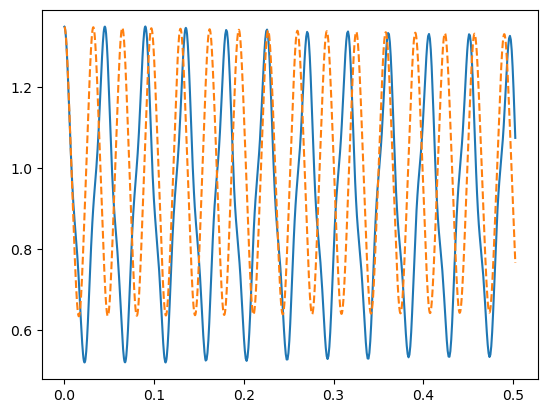

In [64]:
plt.plot(nln_prediction_t, new_nln_predicted_X[749, :]);
plt.plot(new_nln_t_data, new_nln_moving_mesh[-1], '--');

**Energy indicators**

In [65]:
## Non linear model parameters
mu = mu_coeff * rigid / 0.2
A = 1
pres_init0 = 1e5
Ls0 = 1.2
L0 = 1

a = rigid;
b = mu;
c = A * pres_init0;
interm = (((np.sqrt((27 * b * c**2 + 4 * a**3) / b)) / (b * 2 * 3**(3. / 2.))) - c / (2 * b))**(1. / 3.);
u0 = interm - a / (3 * b * interm);
Lse = u0 + Ls0

# Mechanical energy definition (different formula for this nonlinear case)
def nln_mech_nrj(u_dot_t, u_t):
    return .5 * (mass * u_dot_t**2 + rigid * (-u_t - Ls0 + Lse)**2) + mu * .25 * (-u_t - Ls0 + Lse)**4  

nln_predicted_dt = np.concatenate((np.array([nln_t_data[0]]), np.diff(nln_prediction_t)))

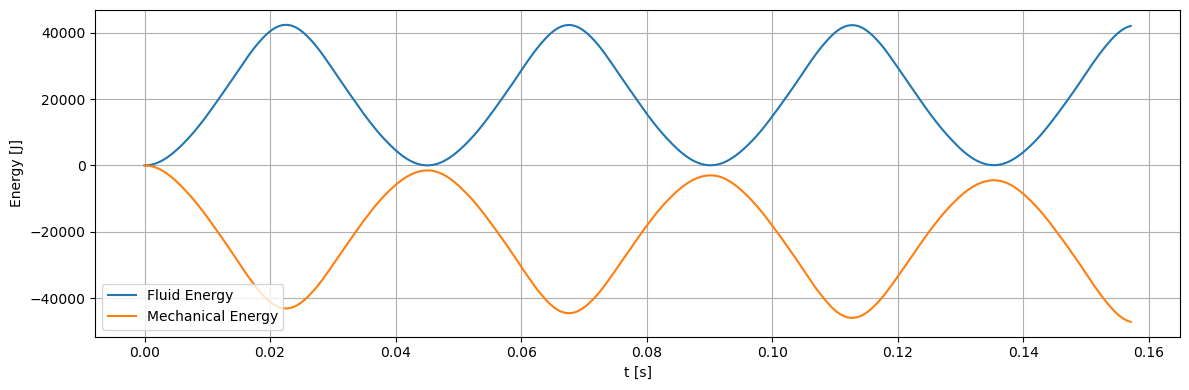

In [66]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_t_data, nln_Imp_fl, label = 'Fluid Energy');
plt.plot(nln_t_data, nln_Em - nln_Em[0], label = 'Mechanical Energy');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

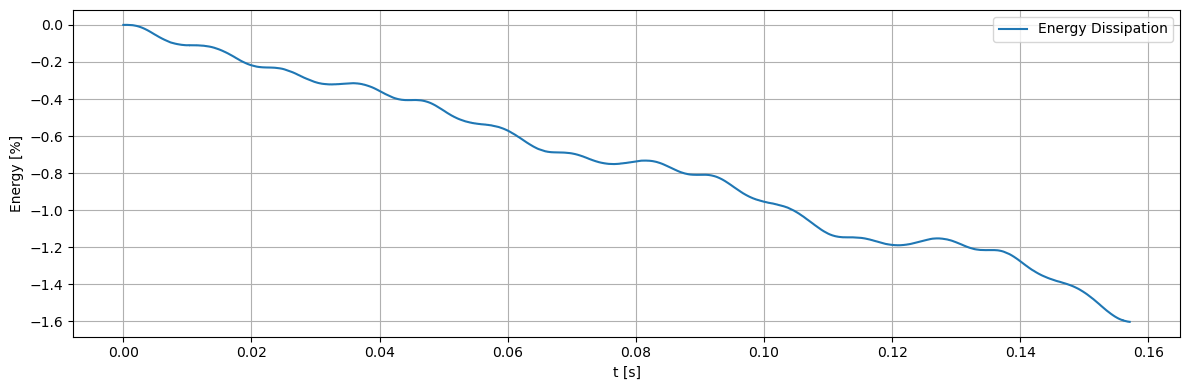

In [67]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_t_data, 100 * (nln_Imp_fl + nln_Em - nln_Em[0])/nln_Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

In [68]:
nlndmd_imp_fl = fl_nrj(nln_predicted_pressure[-1, :], nln_predicted_dt, nln_predicted_velocity[-1, :])
nlndmd_Em = nln_mech_nrj(nln_predicted_velocity[-1, :], nln_predicted_disp[-1, :] - L0)

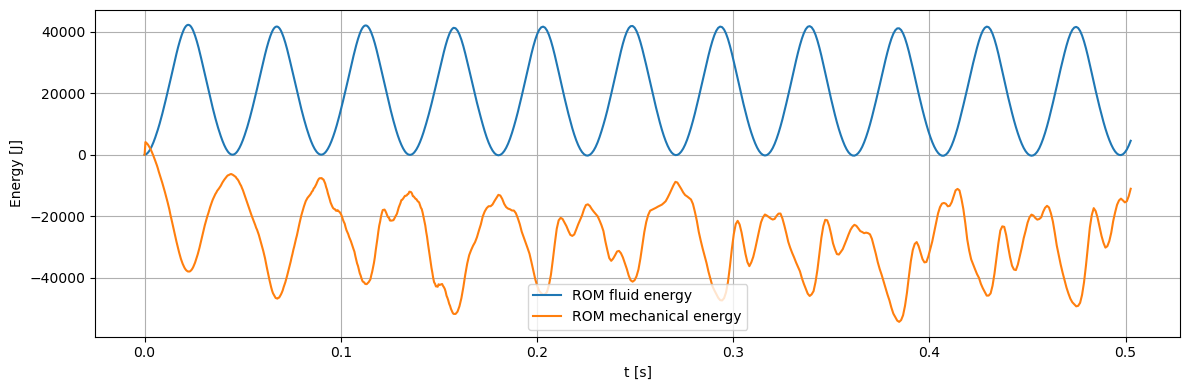

In [69]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_prediction_t, nlndmd_imp_fl, label = 'ROM fluid energy')
plt.plot(nln_prediction_t, nlndmd_Em - nlndmd_Em[0], label = 'ROM mechanical energy')
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

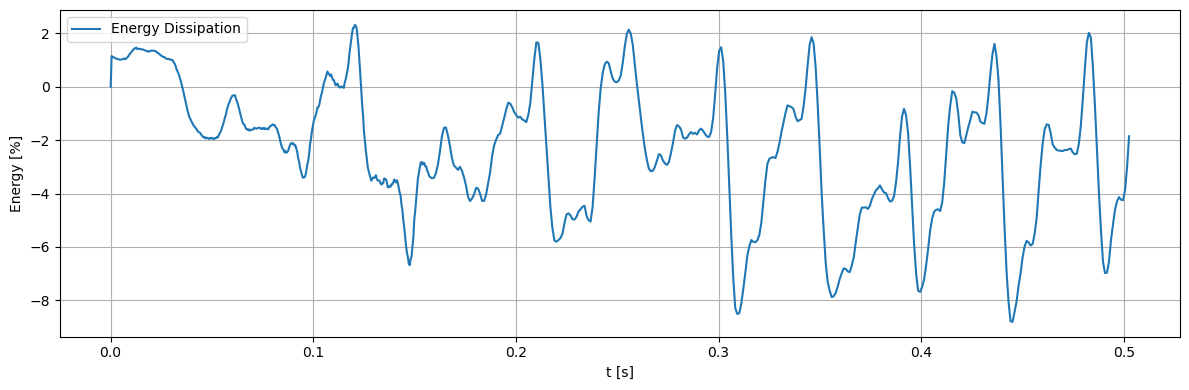

In [70]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_prediction_t, 100 * (nlndmd_imp_fl + nlndmd_Em - nlndmd_Em[0])/nlndmd_Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

-----------------------------------------------------------------------------------------------------------